In [1]:
import boto3
import pandas as pd
import numpy as np
import re
from io import StringIO
import datetime
from dotenv import load_dotenv
import os


In [2]:
# Nazwa bucketu S3
BUCKET_NAME = "zadmod-9"

# Wczytanie zmiennych środowiskowych
load_dotenv()

# Inicjalizacja klienta S3
s3 = boto3.client("s3")

def load_data_from_s3(file_key):
    """Wczytuje dane z S3 do DataFrame."""
    obj = s3.get_object(Bucket=BUCKET_NAME, Key=file_key)
    csv_data = obj['Body'].read().decode('utf-8')
    df = pd.read_csv(StringIO(csv_data), sep=";")
    return df

# Wczytywanie danych dla 2023 i 2024
wroclaw_2023_df = load_data_from_s3("Dane_mod9/halfmarathon_wroclaw_2023__final.csv")
wroclaw_2024_df = load_data_from_s3("Dane_mod9/halfmarathon_wroclaw_2024__final.csv")


In [3]:
# I. KONWERSJA CZASU
def convert_time_to_seconds(time):
    if pd.isnull(time) or time in ['DNS', 'DNF']: #DID NOT START / DID NOT FINISH
        return None
    time = time.split(':')
    return int(time[0]) * 3600 + int(time[1]) * 60 + int(time[2])


In [4]:
# Usuwanie zbędnych kolumn
def get_cleaned_dataframe(df_2023: pd.DataFrame, df_2024: pd.DataFrame) -> pd.DataFrame:
    df_combined = pd.concat([df_2023, df_2024], ignore_index=True)  # Łączenie danych z obu lat
    df_model = df_combined[df_combined['Miejsce'].notnull()].copy() # Usuwanie wierszy z brakującymi miejscami 

    # Usuwanie zbędnych kolumn
    columns_to_drop = ['Drużyna', 'Miasto'] # Wybrane kolumny do usunięcia
    df_model.drop(columns=columns_to_drop, inplace=True)

    return df_model


In [5]:
cleaned_df = get_cleaned_dataframe(wroclaw_2023_df, wroclaw_2024_df)
missing_values_count = cleaned_df.isna().sum().reset_index(name='ilość')


In [6]:
cleaned_df.isna().sum().reset_index(name='ilość')


,index,ilość
0,Miejsce,0
1,Numer startowy,0
2,Imię,0
3,Nazwisko,0
4,Kraj,0
5,Płeć,0
6,Płeć Miejsce,0
7,Kategoria wiekowa,20
8,Kategoria wiekowa Miejsce,20
9,Rocznik,485


In [7]:
# Uzupełnia brakujące wartości w kolumnie 'Rocznik' medianą dla każdej 'Kategorii wiekowej' i dodaje kolumnę 'Wiek
def impute_rocznik_from_category(df: pd.DataFrame) -> pd.DataFrame:
    """
    Uzupełnia brakujące wartości w kolumnie 'Rocznik'
    medianą dla każdej 'Kategorii wiekowej' i dodaje kolumnę 'Wiek'.
    """
    if 'Rocznik' not in df.columns or 'Kategoria wiekowa' not in df.columns:
        return df

    df_result = df.copy()

    # Oblicz medianę 'Rocznik' dla każdej kategorii wiekowej
    median_map = df_result.groupby('Kategoria wiekowa')['Rocznik'].transform('median').round(0).astype('Int64')

    # Uzupełnij brakujące 'Rocznik' medianą odpowiedniej kategorii
    df_result['Rocznik'] = df_result['Rocznik'].fillna(median_map)

    # Dodaj kolumnę 'Wiek'
    df_result['Wiek'] = 2024 - df_result['Rocznik']

    # Usuń kolumnę 'Rocznik'
    df_result = df_result.drop(columns=['Rocznik'])

    # Wyświetl liczby brakujących przed i po
    print(f"Brakujące wartości w 'Rocznik' przed imputacją: {(df['Rocznik'].isnull().sum())}")
    print(f"Brakujące wartości w 'Rocznik' po imputacji: {(df_result['Wiek'].isnull().sum())}")

    return df_result


In [8]:
cleaned_df = get_cleaned_dataframe(wroclaw_2023_df, wroclaw_2024_df)
cleaned_df = impute_rocznik_from_category(cleaned_df)
cleaned_df


Brakujące wartości w 'Rocznik' przed imputacją: 485
Brakujące wartości w 'Rocznik' po imputacji: 0


,Miejsce,Numer startowy,Imię,Nazwisko,Kraj,Płeć,Płeć Miejsce,Kategoria wiekowa,Kategoria wiekowa Miejsce,5 km Czas,...,15 km Czas,15 km Miejsce Open,15 km Tempo,20 km Czas,20 km Miejsce Open,20 km Tempo,Tempo Stabilność,Czas,Tempo,Wiek
0,1.0,1787,TOMASZ,GRYCKO,POL,M,1.0,M30,1.0,00:14:37,...,00:44:47,1.0,3.106667,01:01:43,1.0,3.386667,0.031400,01:04:59,3.080509,32.0
1,2.0,3,ARKADIUSZ,GARDZIELEWSKI,POL,M,2.0,M30,2.0,00:14:48,...,00:45:26,2.0,3.143333,01:03:08,2.0,3.540000,0.038000,01:06:23,3.146875,38.0
2,3.0,3832,KRZYSZTOF,HADAS,POL,M,3.0,M20,1.0,00:15:46,...,00:47:34,3.0,3.236667,01:05:09,3.0,3.516667,0.024067,01:08:24,3.242475,28.0
3,4.0,416,DAMIAN,DYDUCH,POL,M,4.0,M30,3.0,00:16:11,...,00:48:49,5.0,3.330000,01:06:54,4.0,3.616667,0.025467,01:10:16,3.330963,36.0
4,5.0,8476,KAMIL,MAŃKOWSKI,POL,M,5.0,M20,2.0,00:16:12,...,00:49:31,7.0,3.386667,01:07:27,5.0,3.586667,0.023000,01:10:27,3.339654,29.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19245,10298.0,898,EWA KATARZYNA,KASIERSKA,POL,K,3059.0,K70,6.0,00:43:30,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,03:19:47,9.470649,76.0
19246,10299.0,10456,MAGDALENA,PRYNDA,POL,K,3060.0,K40,1030.0,00:42:06,...,02:15:28,10301.0,9.580000,03:10:19,10303.0,10.970000,0.162733,03:21:08,9.534645,46.0
19247,10300.0,11311,HELENA,KOLANY,POL,K,3061.0,K60,48.0,00:49:20,...,02:23:22,10303.0,9.010000,03:11:34,10304.0,9.640000,-0.029333,03:22:18,9.589950,69.0
19248,10301.0,8404,JOANNA,KAJDANEK,POL,K,3062.0,K40,1031.0,00:46:48,...,02:26:03,10304.0,9.980000,03:17:25,10305.0,10.273333,0.057000,03:28:32,9.885439,43.0


In [9]:
# Zmiana kolumn czasu w cleaned_df - Konwersja czasu na sekundy
time_columns = ['5 km Czas', '10 km Czas', '15 km Czas', '20 km Czas', 'Czas']
cleaned_df[time_columns] = cleaned_df[time_columns].applymap(convert_time_to_seconds)

# Teraz wyświetlasz
print(cleaned_df)


       Miejsce  Numer startowy           Imię       Nazwisko Kraj Płeć  \
0          1.0            1787         TOMASZ         GRYCKO  POL    M   
1          2.0               3      ARKADIUSZ  GARDZIELEWSKI  POL    M   
2          3.0            3832      KRZYSZTOF          HADAS  POL    M   
3          4.0             416         DAMIAN         DYDUCH  POL    M   
4          5.0            8476          KAMIL      MAŃKOWSKI  POL    M   
...        ...             ...            ...            ...  ...  ...   
19245  10298.0             898  EWA KATARZYNA      KASIERSKA  POL    K   
19246  10299.0           10456      MAGDALENA         PRYNDA  POL    K   
19247  10300.0           11311         HELENA         KOLANY  POL    K   
19248  10301.0            8404         JOANNA       KAJDANEK  POL    K   
19249  10302.0           11155      Anonimowy       ZAWODNIK  POL    M   

       Płeć Miejsce Kategoria wiekowa  Kategoria wiekowa Miejsce  5 km Czas  \
0               1.0             

C:\Users\Michal\AppData\Local\Temp\ipykernel_20028\3363593751.py:3: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  cleaned_df[time_columns] = cleaned_df[time_columns].applymap(convert_time_to_seconds)


In [10]:
# Usuwanie brakujących wartości
cleaned_df.dropna(subset=time_columns, inplace=True)
print(f"Liczba rekordów po usunięciu brakujących: {len(cleaned_df)}")


Liczba rekordów po usunięciu brakujących: 18377


In [11]:
cleaned_df.isna().sum().reset_index(name='ilość')


,index,ilość
0,Miejsce,0
1,Numer startowy,0
2,Imię,0
3,Nazwisko,0
4,Kraj,0
5,Płeć,0
6,Płeć Miejsce,0
7,Kategoria wiekowa,17
8,Kategoria wiekowa Miejsce,17
9,5 km Czas,0


In [12]:
# Usuwanie outliers

# Funkcja do policzenia liczby outliers w serii
def count_outliers(series):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = series[(series < lower_bound) | (series > upper_bound)]
    return len(outliers)

# Funkcja do usuwania outliers z DataFrame w podanej kolumnie
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)].copy()

# Lista kolumn, z których chcesz usunąć outliers
columns_to_clean = [
    'Tempo', 
    '5 km Czas', '10 km Czas', '15 km Czas', '20 km Czas', 'Czas',
    '5 km Tempo', '10 km Tempo', '15 km Tempo', '20 km Tempo'
]

# Liczba outliers przed usunięciem
outliers_counts = {}
for col in columns_to_clean:
    if col in cleaned_df.columns and pd.api.types.is_numeric_dtype(cleaned_df[col]):
        outliers_counts[col] = count_outliers(cleaned_df[col])

print("--- Liczba outliers przed usunięciem ---")
for col, count in outliers_counts.items():
    print(f"{col}: {count}")

# Usuwanie outliers kaskadowo
for col in columns_to_clean:
    if col in cleaned_df.columns and pd.api.types.is_numeric_dtype(cleaned_df[col]):
        cleaned_df = remove_outliers(cleaned_df, col)

print(f"\nLiczba rekordów po usunięciu outliers: {len(cleaned_df)}")


--- Liczba outliers przed usunięciem ---
Tempo: 222
5 km Czas: 135
10 km Czas: 178
15 km Czas: 203
20 km Czas: 225
Czas: 222
5 km Tempo: 135
10 km Tempo: 256
15 km Tempo: 294
20 km Tempo: 408

Liczba rekordów po usunięciu outliers: 17626


In [13]:
# PRZYGOTOWANIE DANYCH DO MODELU
print("\n" + "="*60)
print("PRZYGOTOWANIE DANYCH DO MODELU")
print("="*60)

model_data = cleaned_df[[
    '5 km Czas', 
    '10 km Czas', 
    '15 km Czas',
    '20 km Czas',
    'Wiek', 
    'Płeć',
    'Czas'
]].copy()

# ✅ DODANIE CECH INTERAKCYJNYCH PRZED SETUPEM
print("\n📊 Tworzenie cech interakcyjnych...")
model_data['time_5km_age'] = model_data['5 km Czas'] * model_data['Wiek']
model_data['time_5km_squared'] = model_data['5 km Czas'] ** 2
model_data['age_squared'] = model_data['Wiek'] ** 2
model_data['time_10km_age'] = model_data['10 km Czas'] * model_data['Wiek']

print(f"📊 Dane: {len(model_data)} rekordów")
print(f"📋 Kolumny: {list(model_data.columns)}")

# Sprawdź korelacje
print("\n📈 Korelacje z czasem końcowym:")
numeric_columns = model_data.select_dtypes(include=[np.number]).columns
correlations = model_data[numeric_columns].corr()['Czas'].sort_values(ascending=False)
print(correlations)


PRZYGOTOWANIE DANYCH DO MODELU

📊 Tworzenie cech interakcyjnych...
📊 Dane: 17626 rekordów
📋 Kolumny: ['5 km Czas', '10 km Czas', '15 km Czas', '20 km Czas', 'Wiek', 'Płeć', 'Czas', 'time_5km_age', 'time_5km_squared', 'age_squared', 'time_10km_age']

📈 Korelacje z czasem końcowym:
Czas                1.000000
20 km Czas          0.999011
15 km Czas          0.989023
10 km Czas          0.970357
5 km Czas           0.941245
time_5km_squared    0.937105
time_10km_age       0.107631
time_5km_age        0.102627
Wiek                0.009265
age_squared         0.000721
Name: Czas, dtype: float64


In [14]:
from pycaret.regression import setup, compare_models, finalize_model, plot_model, save_model, predict_model


In [15]:
# EKSPERYMENT 1: Prosty model
print("EKSPERYMENT 1: Model prosty (5km + 10km + 15km + wiek + płeć)")

exp1 = setup(
    data=model_data,
    target='Czas',
    ignore_features=['20 km Czas', 'time_5km_age', 'time_5km_squared', 
                     'age_squared', 'time_10km_age'],  # Ignoruje cechy interakcyjne
    categorical_features=['Płeć'],
    normalize=True,
    polynomial_features=False,  # Wyłącza automatyczne wielomiany
    remove_outliers=False,
    session_id=123,
    verbose=False,
)

EKSPERYMENT 1: Model prosty (5km + 10km + 15km + wiek + płeć)


In [16]:
best_model_exp1 = exp1.compare_models(sort='MAE')


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
huber,Huber Regressor,79.7870,14166.5325,118.7007,0.9878,0.0155,0.0107,0.0250
lr,Linear Regression,80.8150,14026.7455,118.1449,0.9879,0.0154,0.0108,0.4620
lar,Least Angle Regression,80.8150,14026.7455,118.1449,0.9879,0.0154,0.0108,0.0180
br,Bayesian Ridge,80.8178,14026.7428,118.1451,0.9879,0.0154,0.0108,0.0170
ridge,Ridge Regression,80.9977,14032.6919,118.1805,0.9879,0.0155,0.0109,0.0160
par,Passive Aggressive Regressor,81.3537,14479.8110,119.9881,0.9875,0.0157,0.0109,0.0180
llar,Lasso Least Angle Regression,83.3151,14432.8267,119.9215,0.9875,0.0157,0.0112,0.0150
lasso,Lasso Regression,83.4814,14474.8052,120.0984,0.9875,0.0157,0.0112,0.2650
lightgbm,Light Gradient Boosting Machine,84.0757,14329.0642,119.5380,0.9876,0.0158,0.0113,0.1050
et,Extra Trees Regressor,84.3357,14775.3814,121.3942,0.9872,0.0159,0.0113,0.2600


In [17]:
# EKSPERYMENT 2: Model z cechami interakcyjnymi
print("EKSPERYMENT 2: Model z cechami interakcyjnymi")

exp2 = setup(
    data=model_data,
    target='Czas',
    ignore_features=['20 km Czas'],  # Używa wszystkie cechy
    categorical_features=['Płeć'],
    normalize=True,
    polynomial_features=False,  # Wyłącza automatyczne wielomiany
    remove_outliers=False,
    session_id=124,
    verbose=False,
)

EKSPERYMENT 2: Model z cechami interakcyjnymi


In [18]:
best_model_exp2 = exp2.compare_models(sort='MAE')


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
huber,Huber Regressor,79.6704,13894.1875,117.7641,0.9878,0.0153,0.0106,0.0580
lr,Linear Regression,80.5911,13771.3948,117.2489,0.9879,0.0153,0.0108,0.0210
br,Bayesian Ridge,80.5946,13771.2616,117.2483,0.9879,0.0153,0.0108,0.0210
lar,Least Angle Regression,80.5977,13774.1540,117.2610,0.9879,0.0153,0.0108,0.0190
ridge,Ridge Regression,80.7437,13777.8999,117.2766,0.9879,0.0153,0.0108,0.0190
par,Passive Aggressive Regressor,81.3937,14611.5580,120.7489,0.9872,0.0157,0.0109,0.0230
llar,Lasso Least Angle Regression,82.9494,14195.5508,119.0383,0.9876,0.0156,0.0111,0.0190
lasso,Lasso Regression,83.2043,14270.5305,119.3523,0.9875,0.0156,0.0112,0.0240
rf,Random Forest Regressor,83.7610,14305.0938,119.5327,0.9875,0.0157,0.0112,0.7440
lightgbm,Light Gradient Boosting Machine,84.3166,14350.6611,119.6894,0.9874,0.0158,0.0114,0.1140


In [19]:
# EKSPERYMENT 3: Tylko 5km + wiek + płeć
print("EKSPERYMENT 3: Tylko 5km + wiek + płeć (z interakcjami)")

exp3 = setup(
    data=model_data,
    target='Czas',
    ignore_features=['10 km Czas', '15 km Czas', '20 km Czas', 
                     'time_10km_age'],  # Zostaw time_5km_age!
    categorical_features=['Płeć'],
    normalize=True,
    polynomial_features=False,
    remove_outliers=False,
    session_id=125,
    verbose=False,
)


EKSPERYMENT 3: Tylko 5km + wiek + płeć (z interakcjami)


In [20]:
best_model_exp3 = exp3.compare_models(sort='MAE')


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
huber,Huber Regressor,270.1210,133413.8618,365.1649,0.8846,0.0478,0.0359,0.0290
par,Passive Aggressive Regressor,271.0755,137839.3123,371.1340,0.8807,0.0491,0.0360,0.0200
gbr,Gradient Boosting Regressor,273.9519,131429.5640,362.4512,0.8863,0.0476,0.0367,0.1630
lasso,Lasso Regression,274.2015,131630.9168,362.7343,0.8861,0.0476,0.0367,0.0190
llar,Lasso Least Angle Regression,274.2165,131642.2550,362.7500,0.8861,0.0476,0.0367,0.0180
ridge,Ridge Regression,274.2442,131477.7211,362.5233,0.8862,0.0476,0.0367,0.0190
br,Bayesian Ridge,274.2618,131477.1701,362.5225,0.8862,0.0476,0.0367,0.0170
lr,Linear Regression,274.2974,131476.0173,362.5209,0.8862,0.0476,0.0367,0.0200
lar,Least Angle Regression,274.2974,131476.0173,362.5209,0.8862,0.0476,0.0367,0.0190
omp,Orthogonal Matching Pursuit,274.5144,131948.4136,363.1697,0.8858,0.0477,0.0367,0.0190


In [21]:
# PORÓWNANIE EKSPERYMENTÓW

print("\n" + "="*80)
print("📊 PORÓWNANIE EKSPERYMENTÓW")
print("="*80)

from sklearn.metrics import r2_score

experiments = [
    ('EXP1: Prosty (5+10+15km)', exp1, best_model_exp1),
    ('EXP2: Z interakcjami (5+10+15km)', exp2, best_model_exp2),
    ('EXP3: 5km + interakcje', exp3, best_model_exp3)
]

results = []

for name, exp_obj, model in experiments:
    try:
        holdout_pred = exp_obj.predict_model(model)
        mae = abs(holdout_pred['Czas'] - holdout_pred['prediction_label']).mean()
        r2 = r2_score(holdout_pred['Czas'], holdout_pred['prediction_label'])
        
        results.append({
            'name': name,
            'mae': mae,
            'mae_min': mae/60,
            'r2': r2,
            'exp': exp_obj,
            'model': model
        })
        
        print(f"{name:35s} | MAE: {mae/60:5.2f} min | R²: {r2:.4f}")
        
    except Exception as e:
        print(f"❌ {name}: {str(e)[:50]}")



📊 PORÓWNANIE EKSPERYMENTÓW


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Huber Regressor,81.3530,14312.9720,119.6368,0.9876,0.0156,0.0108


EXP1: Prosty (5+10+15km)            | MAE:  1.36 min | R²: 0.9876


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Huber Regressor,81.5257,14828.1411,121.7709,0.9875,0.0159,0.0109


EXP2: Z interakcjami (5+10+15km)    | MAE:  1.36 min | R²: 0.9875


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Huber Regressor,268.6460,133476.5870,365.3445,0.8846,0.0479,0.0358


EXP3: 5km + interakcje              | MAE:  4.48 min | R²: 0.8846


In [22]:
# Wybór najlepszego
best = min(results, key=lambda x: x['mae'])
exp = best['exp']
best_model = best['model']

print(f"\n🏆 NAJLEPSZY: {best['name']}")
print(f"   MAE: {best['mae_min']:.2f} min | R²: {best['r2']:.4f}")



🏆 NAJLEPSZY: EXP1: Prosty (5+10+15km)
   MAE: 1.36 min | R²: 0.9876


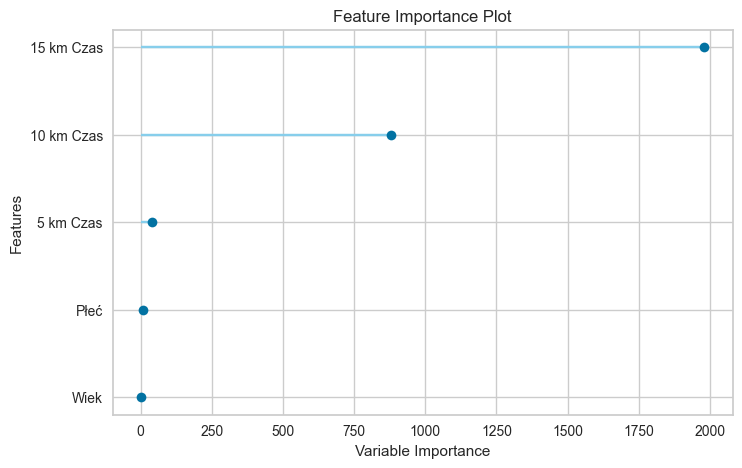

In [23]:
try:
    exp.plot_model(best_model, plot='feature')
except Exception as e:
    print(f"⚠️ Nie można wyświetlić wykresu: {e}")
    # Alternatywnie - pokaż importance jako tekst
    if hasattr(best_model, 'feature_importances_'):
        features = exp.get_config('X').columns
        importances = best_model.feature_importances_
        feat_imp_df = pd.DataFrame({
            'feature': features,
            'importance': importances
        }).sort_values('importance', ascending=False)
        print("\nTop cech:")
        print(feat_imp_df)


In [24]:
# TUNING
print("\n🔧 Strojenie hiperparametrów...")
best_model_tuned = exp.tune_model(
    estimator=best_model,
    n_iter=50,
    optimize='MAE'
)



🔧 Strojenie hiperparametrów...


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,77.2064,12114.9090,110.0677,0.9893,0.0144,0.0103
1,77.4250,12302.0313,110.9145,0.9894,0.0145,0.0104
2,76.8955,12026.6171,109.6659,0.9891,0.0145,0.0104
3,80.6342,14350.7345,119.7946,0.9867,0.0155,0.0107
4,84.6599,18043.4445,134.3259,0.9851,0.0177,0.0113
5,79.7457,13745.3175,117.2404,0.9881,0.0152,0.0106
6,80.0308,14099.2638,118.7403,0.9880,0.0152,0.0105
7,76.0417,13021.6259,114.1123,0.9888,0.0148,0.0102
8,80.0623,14242.6873,119.3427,0.9883,0.0155,0.0107


Fitting 10 folds for each of 50 candidates, totalling 500 fits


In [25]:
# Porównanie przed i po tuningu
orig_pred = exp.predict_model(best_model)
mae_original = float(abs(orig_pred['Czas'] - orig_pred['prediction_label']).mean())
r2_original = float(r2_score(orig_pred['Czas'], orig_pred['prediction_label']))

tuned_pred = exp.predict_model(best_model_tuned)
mae_tuned = float(abs(tuned_pred['Czas'] - tuned_pred['prediction_label']).mean())
r2_tuned = float(r2_score(tuned_pred['Czas'], tuned_pred['prediction_label']))

comparison_df = pd.DataFrame({
    'Model': ['Przed tuningiem', 'Po tuningu'],
    'MAE (min)': [mae_original/60, mae_tuned/60],
    'R²': [r2_original, r2_tuned]
})

print("\n" + comparison_df.to_string(index=False))


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Huber Regressor,81.3530,14312.9720,119.6368,0.9876,0.0156,0.0108


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Huber Regressor,81.3120,14387.3414,119.9472,0.9876,0.0156,0.0108



          Model  MAE (min)       R²
Przed tuningiem   1.355884 0.987617
     Po tuningu   1.355200 0.987553


In [26]:
# Wybiera lepszy model
best_final_model = best_model_tuned if mae_tuned < mae_original else best_model


In [31]:
def predict_time(czas_5km, wiek, plec, czas_10km=None, czas_15km=None):
    """Przewiduje czas półmaratonu.

    Model, który wygrał (EXP1) był trenowany na cechach:
      '5 km Czas', '10 km Czas', '15 km Czas', 'Wiek', 'Płeć'
    Dlatego przy predykcji musimy dostarczyć te kolumny.
    Jeśli użytkownik nie poda 10 km i 15 km, użyjemy prostego przybliżenia
    (2x i 3x 5 km) — pozwala to szybko uzyskać wynik bez błędu nazw cech.
    """
    # Przybliżone wartości 10km/15km jeśli nie podane
    if czas_10km is None:
        czas_10km = 2 * czas_5km
    if czas_15km is None:
        czas_15km = 3 * czas_5km

    # Przygotuj surowe dane zgodne z nazwami kolumn używanymi w pipeline (tak jak podczas fit)
    dane = pd.DataFrame([{
        '5 km Czas': czas_5km,
        '10 km Czas': czas_10km,
        '15 km Czas': czas_15km,
        'Wiek': wiek,
        'Płeć': plec
    }])

    # Użyj obiektu eksperymentu, który trenował model (exp) do predykcji,
    # żeby uniknąć problemów z niezgodnością feature names
    wynik = exp.predict_model(best_final_model, data=dane)
    seconds = int(round(wynik['prediction_label'].iloc[0]))
    return str(datetime.timedelta(seconds=seconds))

# PRZYKŁADY
print("PRZYKŁADY PREDYKCJI")

print(f"Mężczyzna 28 lat → {predict_time(1500, 28, 'M')}")
print(f"Mężczyzna 55 lat → {predict_time(1500, 55, 'M')}")
print(f"Kobieta 28 lat   → {predict_time(1500, 28, 'K')}")
print(f"Mężczyzna 35 lat (wolniejszy) → {predict_time(2000, 35, 'M')}")

print("\n" + "="*60)

PRZYKŁADY PREDYKCJI


Mężczyzna 28 lat → 1:46:31


Mężczyzna 55 lat → 1:46:31


Kobieta 28 lat   → 1:46:12


Mężczyzna 35 lat (wolniejszy) → 2:22:04

